<a href="https://colab.research.google.com/github/MammadovN/Machine_Learning/blob/main/projects/03_deep_learning/word_embedding/word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Colab Notebook: Word Embedding Project (Drive-Free)

# 00. Environment Setup
#@title 00. Environment Setup
!pip install --quiet --upgrade scipy==1.10.1 gensim==4.3.1 pandas scikit-learn matplotlib nltk tensorflow

# SciPy patch: if scipy.linalg.triu is missing, use numpy.triu
import scipy.linalg as linalg
import numpy as np
if not hasattr(linalg, 'triu'):
    linalg.triu = np.triu

print("Environment is ready!")


Environment is ready!


In [13]:
# 01. Data Preparation (NLTK Gutenberg)
#@title 01. Data Preparation
from nltk.corpus import gutenberg
import re

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Split raw text into sentences and tokenize words using simple .split()
sentences = []
for file_id in gutenberg.fileids():
    raw_text = gutenberg.raw(file_id)
    for segment in re.split(r"[\.!?]", raw_text):
        cleaned = clean_text(segment)
        tokens = cleaned.split()
        if tokens:
            sentences.append(tokens)

print(f"Total of {len(sentences)} sentences prepared.")


Total of 100533 sentences prepared.


In [14]:
# 02. Embedding Training
#@title 02. Embedding Training
from gensim.models import Word2Vec, FastText

# Word2Vec
w2v_model = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=5,
    sg=1,
    epochs=5,
    workers=4
)
w2v_model.save('word2vec.model')
print("Word2Vec model saved as: word2vec.model")

# FastText
ft_model = FastText(
    sentences,
    vector_size=100,
    window=5,
    min_count=5,
    sg=1,
    epochs=5,
    workers=4
)
ft_model.save('fasttext.model')
print("FastText model saved as: fasttext.model")


Word2Vec model saved as: word2vec.model
FastText model saved as: fasttext.model


king - man + woman => [('vashti', 0.5499433279037476), ('daughter', 0.5323252081871033), ('babylon', 0.5257881283760071), ('esther', 0.5222809314727783), ('laban', 0.5183823704719543)]
similarity between king & queen: 0.48619074


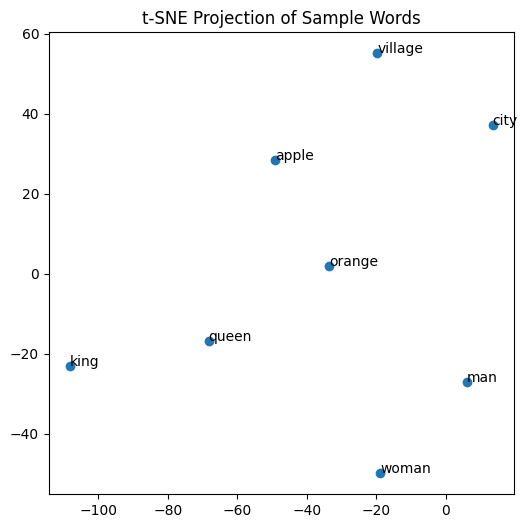

In [15]:
# 03. Intrinsic Evaluation
#@title 03. Intrinsic Evaluation

from gensim.models import Word2Vec
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the Word2Vec model and get access to its KeyedVectors
loaded_w2v = Word2Vec.load('word2vec.model')
w2v = loaded_w2v.wv

# Example analogy and similarity queries
print("king - man + woman =>", w2v.most_similar(positive=['king', 'woman'], negative=['man'], topn=5))
print("similarity between king & queen:", w2v.similarity('king', 'queen'))

# t-SNE visualization (using a small perplexity since sample size is small)
words = ['king', 'queen', 'man', 'woman', 'apple', 'orange', 'city', 'village']
# Convert vectors to a NumPy array
vecs = np.array([w2v[word] for word in words])
# Ensure perplexity < number of samples (here 5 < 8)
X_tsne = TSNE(n_components=2, random_state=42, perplexity=5).fit_transform(vecs)

plt.figure(figsize=(6, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, (X_tsne[i, 0], X_tsne[i, 1]))
plt.title('t-SNE Projection of Sample Words')
plt.show()

In [16]:
# 04. Downstream Task: IMDB Sentiment Analysis
#@title 04. Sentiment Analysis (Keras IMDB)

import numpy as np
from tensorflow.keras.datasets import imdb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# 1) Load data
top_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
word_index = imdb.get_word_index()
# Reserve indices for special tokens
index_word = {v + 3: k for k, v in word_index.items()}
index_word.update({0: '<PAD>', 1: '<START>', 2: '<UNK>', 3: '<UNUSED>'})

# Decode integer sequences back into words
def decode_review(sequence):
    return [index_word.get(i, '?') for i in sequence]

train_texts = [' '.join(decode_review(seq)) for seq in X_train]
test_texts  = [' '.join(decode_review(seq)) for seq in X_test]

# 2) Convert texts into embedding vectors
def embed_texts(texts, model):
    vectors = []
    for text in texts:
        tokens = text.split()
        # Collect word vectors for tokens present in the model
        word_vectors = [model[token] for token in tokens if token in model]
        # Use mean pooling or zero vector if no tokens found
        if word_vectors:
            vectors.append(np.mean(word_vectors, axis=0))
        else:
            vectors.append(np.zeros(model.vector_size))
    return np.vstack(vectors)

X_tr = embed_texts(train_texts, w2v)
X_te = embed_texts(test_texts,  w2v)

y_tr, y_te = y_train, y_test

# 3) Classification with Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_tr, y_tr)
preds = clf.predict(X_te)

print("Accuracy:", accuracy_score(y_te, preds))
print("F1-score:", f1_score(y_te, preds))


Accuracy: 0.73332
F1-score: 0.7301574452584287
